{'Channels_Coupling': {'amplitude': [], 'channels': []},
 'Noise': {'channel': [], 'index': [], 'slope': []},
 'Pulse': {'amplitude': [-0.7737723737894179,
                         0.1727345659879327,
                         0.19652105966450262,
                         -0.07460325775484833,
                         -0.6216060711314727,
                         -1.3072468179155265,
                         1.436457437272928,
                         -0.48087646908640913,
                         -0.014854107352637147,
                         1.4312421777680453,
                         -0.17767852529800043,
                         -0.5451815835631464,
                         0.05939095762614044,
                         0.23440928964740237,
                         1.0618012515014592,
                         -1.2957081793861498,
                         -0.10640757666200251,
                         0.8458473558574453,
                         0.6558084311467507,
                 

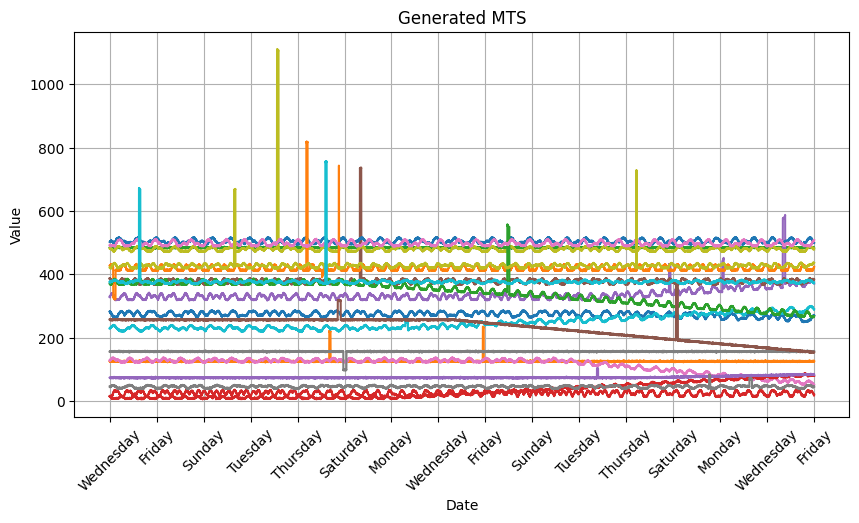

In [1]:
%load_ext autoreload
%autoreload 2
import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import train_on_effect
from train import train, train_MCMC, slidingWindow, criterion

import numpy as np
import matplotlib.pyplot as plt
import pprint
# all parameters for generating the time series should be configured in this cell
periode = 30 #days
step = 5 # mess interval in minutes
val = 500
n_channels = 20
effects = {
    "Pulse": {
        "occurances":30,
        "max_amplitude":1.5,   
        "interval":40
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.005,
        "type":"linear"
        },
    "Seasonality": {
        "occurances":35,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":1000,
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

X = Gen(periode, step, val, n_channels, effects)
x, params, e_params = X.parameters()
# pprint.pprint(params)
pprint.pprint(e_params)
X.show()



In [2]:
### Init Model
latent_dims = 7 # 6 # 17
L= 3455# 39 #32
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# v = Variational_Autoencoder(n_channels = n_channels,
#                             num_layers =  3,#4, #3
#                             latent_dims= latent_dims,
#                             v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
#                             v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
#                             L=L,
#                             slope = 0,
#                             first_kernel = 20, #11, #20
#                             ß = 1.5,
#                             modified=True,
#                             reduction = True)
v = VQ_MST_VAE(n_channels = n_channels,
                            num_layers =  3,#4, #3
                            latent_dims= latent_dims,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                            v_quantizer = VQ_Quantizer,
                            L=L,
                            slope = 0,
                            first_kernel = 15, #11, #20
                            commit_loss = 2,
                            modified=True,
                            reduction = False) #10 5


v = v.to(device)

opt = optim.Adam(v.parameters(), lr = 0.005043529186448577) # 0.005043529186448577 0.006819850049647945
print(v)
x = torch.FloatTensor(x)
n = x.shape[1]

train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

train_data = DataLoader(slidingWindow(train_, L),
                        batch_size= 22,# 59, # 22
                        shuffle = False
                        )
val_data = DataLoader(slidingWindow(val_, L),
                        batch_size=22,
                        shuffle = False
                        )
test_data = DataLoader(slidingWindow(test_, L),
                        batch_size=22,
                        shuffle = False
                        )

20
240
20
240
VQ_MST_VAE(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder_unified(
      (cnn_layers): ModuleList(
        (0): Conv1d(20, 40, kernel_size=(2,), stride=(2,))
        (1): LeakyReLU(negative_slope=0, inplace=True)
        (2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(40, 80, kernel_size=(2,), stride=(2,))
        (4): LeakyReLU(negative_slope=0, inplace=True)
        (5): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(80, 120, kernel_size=(2,), stride=(2,))
        (7): LeakyReLU(negative_slope=0, inplace=True)
        (8): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder_mu): Linear(in_features=431, out_features=7, bias=True)
      (encoder_logvar): Linear(in_features=431, out_features=7, bias=True)
    )
    (long_encoder): TCVAE_Encoder_unified(
      (cnn_layers): ModuleList(
  

In [3]:
v, X, train_data = train_on_effect(v, opt, device, n_channels=n_channels, effect='no_effect', n_samples=3)
v, X, train_data = train_on_effect(v, opt, device, n_channels=n_channels, effect='trend', n_samples=3)
v, X, train_data = train_on_effect(v, opt, device, n_channels=n_channels, effect='seasonality', n_samples=3)

Train Epoch: 1 [0/1 (0%)]	Loss: 152806.281250
====> Epoch: 1 Average loss: 152806.2812
Train Epoch: 2 [0/1 (0%)]	Loss: 150430.765625
====> Epoch: 2 Average loss: 150430.7656
Train Epoch: 3 [0/1 (0%)]	Loss: 143918.171875
====> Epoch: 3 Average loss: 143918.1719
Train Epoch: 4 [0/1 (0%)]	Loss: 138024.359375
====> Epoch: 4 Average loss: 138024.3594
Train Epoch: 5 [0/1 (0%)]	Loss: 130686.804688
====> Epoch: 5 Average loss: 130686.8047
Train Epoch: 6 [0/1 (0%)]	Loss: 116299.414062
====> Epoch: 6 Average loss: 116299.4141
Train Epoch: 7 [0/1 (0%)]	Loss: 98476.109375
====> Epoch: 7 Average loss: 98476.1094
Train Epoch: 8 [0/1 (0%)]	Loss: 109887.078125
====> Epoch: 8 Average loss: 109887.0781
Train Epoch: 9 [0/1 (0%)]	Loss: 86209.804688
====> Epoch: 9 Average loss: 86209.8047
Train Epoch: 10 [0/1 (0%)]	Loss: 76229.406250
====> Epoch: 10 Average loss: 76229.4062
Train Epoch: 11 [0/1 (0%)]	Loss: 60018.957031
====> Epoch: 11 Average loss: 60018.9570
Train Epoch: 12 [0/1 (0%)]	Loss: 49671.312500
=

RuntimeError: Parent directory modules does not exist.

In [4]:
for epoch in range(1, 10):
    train(v, train_data, criterion, opt, device, epoch, VQ = True)

Train Epoch: 1 [0/3457 (0%)]	Loss: 9919.816051
Train Epoch: 1 [2200/3457 (63%)]	Loss: 1519.071555


KeyboardInterrupt: 

Train Epoch: 1 [0/3457 (0%)]	Loss: 2297.933239
Train Epoch: 1 [2200/3457 (63%)]	Loss: 403.450373
====> Epoch: 1 Average loss: 1288.9893



KeyboardInterrupt



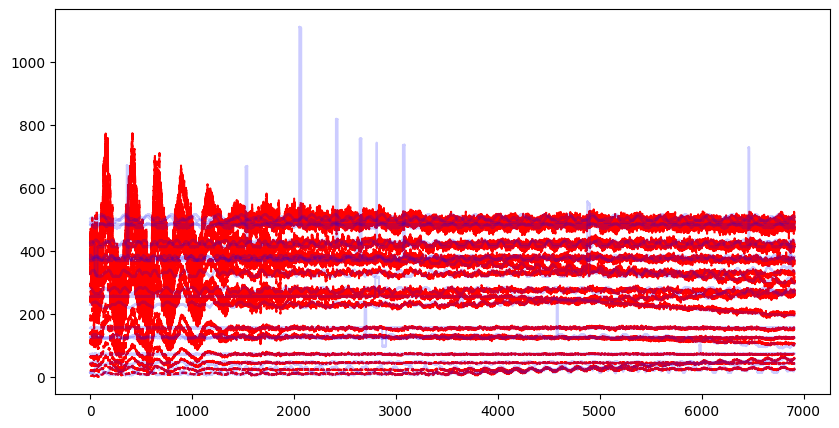

In [5]:
for epoch in range(1, 5):
    train_MCMC(v, train_data, criterion, opt, device, epoch, VQ = True, repetitions=3)

In [120]:
def compare(dataset, model, VQ=True):
    model.eval()
    rec = []
    x = []
    T = dataset.dataset.data.shape[1]- L
    idx = 0
    _mu_rec, _logvar_rec = [], []
    _mu, _logvar = [], []
#     _mu, _logvar = (torch.empty((n_channels * 2, T, L)) for _ in range(2))
#     _mu_rec, _logvar_rec = (torch.empty((T, n_channels)) for _ in range(2))
    with torch.no_grad():
        for i, (data, v) in enumerate(dataset):
            bs = data.shape[0]
            if VQ:
                x_rec, loss, mu, logvar, mu_rec, logvar_rec = model(data)
            else:
                x_rec, mu, logvar = model(data)
            z = model.reparametrization_trick(mu, logvar)
            if v.dim() == 1:
                v = v.unsqueeze(0)
                v = v.T
                v = v.unsqueeze(-1)
#             print(v.shape)
#             print(x_rec.shape)
#             print((x_rec * v).shape)
#             print(i)
#             print(mu.shape)

            x.extend((data)[0,:,0].detach().numpy())
            rec.extend(((x_rec)[0,:,0]).detach().numpy())
            _mu_rec.extend((mu_rec)[0,:,:].detach().numpy())
            _logvar_rec.extend(((torch.exp(0.5 * logvar_rec)))[0,:,:].detach().numpy())
            
            _mu.extend((mu)[0,:,0].detach().numpy())
            _logvar.extend(((torch.exp(0.5 * logvar)))[0,:,:].detach().numpy())
#             _mu[idx: idx + bs, :, :] = mu
#             _mu_rec[idx: idx + bs, :] = (mu_rec*v)[:,:,0]
#     print(np.array(_mu).shape)
    
#     x = np.array(x).T
#     rec = np.array(rec).T
#     _mu = np.tile(np.array(_mu), (3455, 1))
#     _logvar = np.tile(np.array(_logvar), (3455, 1))
#     _mu_rec = np.tile(np.array(_mu_rec), (3455, 1))
#     _logvar_rec = np.tile(np.array(_logvar_rec), (3455, 1))
#     print(_logvar.shape)
#     print(x.shape)
#     print(rec.shape)
#     print(T)
#     print(params["cov"][0,:,:L].T)
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))
    ax = axs[0]
    ax.plot(rec, "r-")
    ax.plot(x[:], "b-", alpha=0.2)
    ax.plot(_mu_rec)
    ax.plot(params["mu"].T[:_mu.shape[0],:])
    ax.grid()
    
    ax_std = axs[1]
    ax_std.plot(_logvar_rec, "r")
    ax_std.plot(params["cov"][0,:,:L].T, "b")
    ax_std.grid()
    
    ax_enc = axs[2]
    for (i,l) in enumerate(_mu.T):        
        ax_enc.plot(l.T, alpha = (0.2 + 0.1*i))
#     ax_enc.plot(_mu, alpha = 0.2)
    ax_enc.grid()
    
    ax_log = axs[3]
    for (i,l) in enumerate(_logvar.T):        
        ax_log.plot(l.T, alpha = (0.2 + 0.1*i))
    ax_log.grid()
    
    # Setting legend
    blue_handle = plt.Line2D([], [], color='b', label='Original Data', alpha=0.2)
    red_handle = plt.Line2D([], [], color='r', label='Reconstructions mean')
    titles = ['Prediction of Train Data', 'Std plot', 'mu encoder vs mu from gen', 'logvar encoder vs cov']
    for (i,ax) in enumerate(axs):
        # ax.set_title('Reconstruction of Train Data')
        ax.set_title(titles[i])
        ax.legend(handles=[blue_handle, red_handle], loc="upper right")
    
    
    # Axes labels
    ax_std.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax_std.set_ylabel('Values')
#     plt.ylim(-100,500)
#     plt.grid(True)
    fig.tight_layout()
    plt.show()
# def compare(dataset, model, VQ=True):
#     model.eval()
#     rec = []
#     x = []
#     T = dataset.dataset.data.shape[1]- L
#     idx = 0
#     _mu_rec, _logvar_rec = [], []
#     _mu, _logvar = [], []
# #     _mu, _logvar = (torch.empty((n_channels * 2, T, L)) for _ in range(2))
# #     _mu_rec, _logvar_rec = (torch.empty((T, n_channels)) for _ in range(2))
#     with torch.no_grad():
#         for i, (data, v) in enumerate(dataset):
#             bs = data.shape[0]
#             if VQ:
#                 x_rec, loss, mu, logvar, mu_rec, logvar_rec = model(data)
#             else:
#                 x_rec, mu, logvar = model(data)
#             z = model.reparametrization_trick(mu, logvar)
#             print(v.shape)
#             if v.dim() == 1:
#                 v = v.unsqueeze(0)
#                 v = v.T
#                 v = v.unsqueeze(-1)
# #             print(v.shape)
# #             print(x_rec.shape)
# #             print((x_rec * v).shape)
# #             print(i)
# #             print(mu.shape)

#             x.extend((data)[:,:,:].detach().numpy())
#             rec.extend(((x_rec)[:,:,:]).detach().numpy())
# #             _mu_rec.extend((mu_rec*v)[:,:,0].detach().numpy())
# #             _logvar_rec.extend(((torch.exp(0.5 * logvar_rec))*v)[:,:,0].detach().numpy())
            
# #             _mu.extend((mu*v)[:,:,0].detach().numpy())
# #             _logvar.extend(((torch.exp(0.5 * logvar))*v)[:,:,0].detach().numpy())
# #             _mu[idx: idx + bs, :, :] = mu
# #             _mu_rec[idx: idx + bs, :] = (mu_rec*v)[:,:,0]
# #     print(np.array(rec).shape)
# #     _mu = np.array(_mu)
# #     _logvar = np.array(_logvar)
    
#     rec = np.array(rec).squeeze(0).T
#     x = np.array(x).squeeze(0).T
# #     print(x.shape)
# #     print(rec)
#     fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
#     ax = axs#[0]
#     ax.plot(rec, "r-")
#     ax.plot(x, "b-", alpha=0.2)
# #     ax.plot(_mu_rec)
# #     ax.plot(params["mu"].T[:_mu.shape[0],:])
#     ax.grid()
    
# #     ax_std = axs[1]
# #     ax_std.plot(_logvar_rec, "r")
# #     ax_std.plot(params["cov"][0,:,:T].T, "b")
# #     ax_std.grid()
    
# #     ax_enc = axs[2]
# #     for (i,l) in enumerate(_mu.T):        
# #         ax_enc.plot(l.T, alpha = (0.2 + 0.1*i))
# # #     ax_enc.plot(_mu, alpha = 0.2)
# #     ax_enc.grid()
    
# #     ax_log = axs[3]
# #     for (i,l) in enumerate(_logvar.T):        
# #         ax_log.plot(l.T, alpha = (0.2 + 0.1*i))
# #     ax_log.grid()
    
#     # Setting legend
#     blue_handle = plt.Line2D([], [], color='b', label='Original Data', alpha=0.2)
#     red_handle = plt.Line2D([], [], color='r', label='Reconstructions mean')
# #     for ax in axs:
#         # ax.set_title('Reconstruction of Train Data')
#     ax.set_title('Prediction of Test (unseen) Data')
#     ax.legend(handles=[blue_handle, red_handle], loc="upper right")
    
    
#     # Axes labels
# #     ax_std.set_xlabel('Time')
# #     ax.set_ylabel('Values')
# #     ax_std.set_ylabel('Values')
# #     plt.ylim(-100,500)
#     plt.grid(True)
#     fig.tight_layout()
#     plt.show()

In [12]:
def compare(dataset, model, VQ=True):
    model.eval()
    rec = []
    x = []
    with torch.no_grad():
        for i, (data, v) in enumerate(dataset):
            if VQ:
                x_rec, loss, mu, logvar, mu_rec, logvar_rec = model(data)
            else:
                x_rec, mu, logvar = model(data)
            z = model.reparametrization_trick(mu, logvar)
            if v.dim() == 1:
                v = v.unsqueeze(0)
                v = v.T
                v = v.unsqueeze(-1)
#             print(v.shape)
#             print(x_rec.shape)
#             print((x_rec * v).shape)
#             print(i)

            x.extend(((data*v)[:,:,0].detach().numpy()))
            rec.extend((((x_rec*v)[:,:,0]).detach().numpy()))
#     print(rec)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(rec, "r--")
    ax.plot(x[:], "b-", alpha=0.2)
#     plt.ylim(50,600)
    plt.grid(True)
    plt.show()
    
    new_train_data = DataLoader(slidingWindow(np.array(rec).T, L),
                        batch_size= 22,# 59, # 22
                        shuffle = False
                        )
    return new_train_data

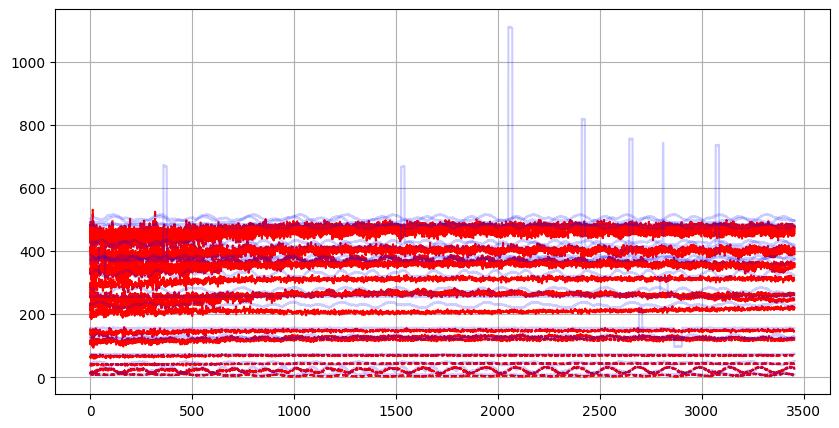

VQ_MST_VAE(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder_unified(
      (cnn_layers): ModuleList(
        (0): Conv1d(20, 40, kernel_size=(2,), stride=(2,))
        (1): LeakyReLU(negative_slope=0, inplace=True)
        (2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(40, 80, kernel_size=(2,), stride=(2,))
        (4): LeakyReLU(negative_slope=0, inplace=True)
        (5): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(80, 120, kernel_size=(2,), stride=(2,))
        (7): LeakyReLU(negative_slope=0, inplace=True)
        (8): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder_mu): Linear(in_features=431, out_features=7, bias=True)
      (encoder_logvar): Linear(in_features=431, out_features=7, bias=True)
    )
    (long_encoder): TCVAE_Encoder_unified(
      (cnn_layers): ModuleList(
        (0): Con

In [14]:
# a = 15* avg_norm
# v.quantizer._embedding.weight.detach()[0,5] = a
v.cpu()
rec = compare(train_data, v, VQ=True)
v.to(device)

In [87]:
def plot_heatmap(ax_heatmap, codebook):
    ax_heatmap.clear()
    heatmap = ax_heatmap.imshow(codebook)
    ax_heatmap.set_title('Codebook Heatmap')
    ax_heatmap


    return heatmap
def create_heatmap(codebook):
    fig, ax_heatmap = plt.subplots(figsize=(12, 6), dpi=100)
    heatmap = plot_heatmap(ax_heatmap, codebook.T)
#     heatmap_canvas = FigureCanvasTkAgg(fig, master=heatmap_frame)
#     heatmap_canvas.draw()
#     heatmap_canvas.get_tk_widget().pack(fill="both", expand=True)
    cbar = fig.colorbar(heatmap)
    ax_heatmap.set_xlabel('Num of Embeddings')
    ax_heatmap.set_ylabel('Latent Dimensions')
    
    return ax_heatmap

def get_average_norm_scale(train_data, model):
    n_channels = model._n_channels
    n_batchs = x_size = len(train_data)
    
    norm = torch.empty(n_channels, 0)

    for i, (data, norm_scale) in enumerate(train_data):
        reshaped_norm = norm_scale.permute(1,0,2).flatten(1)
        norm = torch.cat((norm, reshaped_norm), 1)
        
    avg_norm = torch.mean(norm, dim=1)
    return avg_norm

def get_latent_variables(train_data, model):
    model.eval()
    
    n_channels = model._n_channels
    latent_dims = model._latent_dims
    n_batchs = x_size = len(train_data)
    
    latents = torch.empty(n_channels, latent_dims, 0, device = device)

    for i, (data, norm_scale) in enumerate(train_data):
        data = data.to(device)
        
        mu, logvar = model.encoder(data)
        z = model.reparametrization_trick(mu, logvar)
        
        reshaped_mu, reshaped_logvar, reshaped_z = (t.permute(1,2,0) for t in [mu, logvar, z])

        latents = torch.cat((latents, reshaped_z), 2)

        
    avg_latents = torch.mean(latents, dim=2)
    return latents, avg_latents

In [156]:
def sample_vae(train_data, model, n):
    model.eval()
    
    n_channels = model._n_channels
    latent_dims = model._latent_dims
#     n_batchs = x_size = len(train_data)
    x_len = len(train_data.dataset)
    L = model._L
    bs = train_data.batch_size
    
    latents = torch.empty(n_channels, latent_dims, 0, device = device)
    x_rec, mu_dec, logvar_dec = (torch.empty(0, n_channels, x_len, device = device) for _ in range(3))
    mu_enc, logvar_enc = (torch.empty(0, n_channels, latent_dims, x_len, device = device) for _ in range(2))
    
    for j in range(n):
        # create temp tensors to store data in each repetition
        x, x_rec_temp, mu_rec_temp, logvar_rec_temp = (torch.empty(n_channels, 0, device = device) for _ in range(4))
        mu_temp, logvar_temp = (torch.empty(n_channels, latent_dims, 0, device = device) for _ in range(2))
        
        for i, (batch, norm_scale) in enumerate(train_data):
            batch = batch.to(device)
            #sample from model
            rec, loss, _mu, _logvar, mu_rec, logvar_rec = model(batch)

            #reshape data -> (Channel, latent_dims, BS) or (Channel, BS)
            _mu, _logvar= (t.permute(1,2,0) for t in [_mu, _logvar])
            batch, rec, norm_scale, mu_rec, logvar_rec = (t.permute(1,0,2)[:,:,0] for t in [batch, rec, norm_scale, mu_rec, logvar_rec])
            
            # Temp store data
            mu_temp = torch.cat((mu_temp, _mu), dim=2)
            logvar_temp = torch.cat((logvar_temp, _logvar), dim=2)
            mu_rec_temp = torch.cat((mu_rec_temp, mu_rec*norm_scale), dim=1)
            logvar_rec_temp  = torch.cat((logvar_rec_temp, logvar_rec*norm_scale), dim=1)            
            x_rec_temp = torch.cat((x_rec_temp, rec*norm_scale), dim=1)
#             print(batch.shape)
#             print(norm_scale.shape)
#             print(x.shape)
            x = torch.cat((x, batch*norm_scale), dim=1)

        # Store data after each reconstruction
        x_rec = torch.cat((x_rec, x_rec_temp.unsqueeze(0)), dim=0)
        mu_dec = torch.cat((mu_dec, mu_rec_temp.unsqueeze(0)), dim=0)
        logvar_dec = torch.cat((logvar_dec, logvar_rec_temp.unsqueeze(0)), dim=0)
        mu_enc = torch.cat((mu_enc, mu_temp.unsqueeze(0)), dim=0)
        logvar_enc = torch.cat((logvar_enc, logvar_temp.unsqueeze(0)), dim=0)
        print(x.shape)

    # join repetition and Channels and get the mean
#     x_rec, mu_dec, logvar_dec = (t.view(-1, x_len)for t in [x_rec, mu_dec, logvar_dec])
    x_rec_mean, mu_enc_mean, logvar_enc_mean, mu_dec_mean, logvar_dec_mean = (torch.mean(t, dim=0) for t in [x_rec, mu_enc, logvar_enc, mu_dec, logvar_dec])
#     x_rec_mean = x_rec.mean(0)
    print(x_rec.shape)
    print(x_rec_mean.shape)
    print(mu_enc_mean.shape)
    print(mu_dec_mean.shape)
    
    return x_rec, x_rec_mean, mu_enc_mean, logvar_enc_mean, mu_dec_mean, logvar_dec_mean

In [157]:
sample_vae(train_data, v, 5)

torch.Size([1, 3396])
torch.Size([1, 3396])
torch.Size([1, 3396])
torch.Size([1, 3396])
torch.Size([1, 3396])
torch.Size([5, 1, 3396])
torch.Size([1, 3396])
torch.Size([1, 7, 3396])
torch.Size([1, 3396])


(tensor([[[270.6336, 270.8838, 264.7929,  ..., 264.1872, 266.1580, 266.2314]],
 
         [[267.2577, 267.1277, 265.2807,  ..., 263.2624, 269.6062, 269.7383]],
 
         [[267.2337, 268.0678, 267.6342,  ..., 269.5417, 268.7584, 265.9521]],
 
         [[264.8954, 275.5269, 271.7399,  ..., 270.9635, 260.7353, 267.1324]],
 
         [[263.9909, 263.8148, 270.3807,  ..., 263.0367, 270.1438, 264.7582]]],
        grad_fn=<CatBackward0>),
 tensor([[266.8022, 269.0842, 267.9657,  ..., 266.1983, 267.0803, 266.7625]],
        grad_fn=<MeanBackward1>),
 tensor([[[ 4.8745e-05,  2.3223e-04,  1.9234e-04,  ..., -5.7731e-05,
            1.0282e-04,  7.4898e-05],
          [ 1.7370e-04,  2.2830e-04,  1.7567e-04,  ...,  7.5044e-05,
            2.1233e-04,  2.6535e-05],
          [ 1.2812e-04,  2.7792e-04,  1.7135e-04,  ...,  1.8889e-04,
            2.2300e-04,  4.6355e-05],
          ...,
          [ 2.5057e-04,  2.1517e-04,  1.7004e-04,  ...,  1.5335e-04,
            1.1291e-04,  1.6399e-04],
        

In [89]:
get_latent_variables(train_data, v)
x, params, e_params = X.parameters()

In [90]:
pprint.pprint(params)
pprint.pprint(e_params)

{'cov': array([[[1., 1., 1., ..., 1., 1., 1.]]], dtype=float32),
 'mu': array([[230., 230., 230., ..., 230., 230., 230.]], dtype=float32),
 'n': 4320,
 'nchannels': 1}
{'Channels_Coupling': {'amplitude': [], 'channels': []},
 'Noise': {'channel': [], 'index': [], 'slope': []},
 'Pulse': {'amplitude': [], 'channel': [], 'index': []},
 'Seasonality': {'amplitude': [8],
                 'channel': [0],
                 'frequency_per_week': [10.700296455459206],
                 'phaseshift': [112]},
 'Std_variation': {'amplitude': [], 'channel': [], 'interval': []},
 'Trend': {'channel': [], 'index': [], 'slope': []}}


tensor([232.5528])
[[-17.949327 -17.343847 -16.520227 -14.839128  14.523157 -18.045221
  -15.465867]]


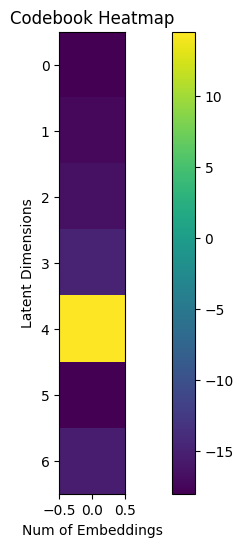

In [94]:
from matplotlib.figure import Figure
np.set_printoptions(suppress=True)
avg_norm = get_average_norm_scale(train_data, v)
print(avg_norm)
# latents, avg_latents = get_latent_variables(train_data, v)
codebook = v.quantizer._embedding.weight
heatmap = create_heatmap(codebook.cpu().detach().numpy() * avg_norm.numpy())
print((codebook.cpu().detach().numpy() * avg_norm.numpy() ))